# EDSR architecture on DIV2K dataset

(Enhanced deep superresolution)


In [21]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# tracking
import os
import time
from datetime import datetime

# for dataset
import tensorflow_datasets as tfds

### Define parameters


In [22]:
SCALE = 2
BATCH_SIZE = 16
EPOCHS = 150
LR = 1e-4
OUTPUT_DIR = "edsr_output"
PATCH_SIZE = (128, 128)

### Data Preprocessing


In [34]:
def preprocess_div2k(lr, hr, rgb_mean=[0.4488, 0.4371, 0.4040], fixed_size=None):
    # Cast to float32 and normalize to [0, 1]
    lr = tf.cast(lr, tf.float32) / 255.0
    hr = tf.cast(hr, tf.float32) / 255.0

    # Convert mean to tensor and subtract
    # rgb_mean = tf.reshape(tf.constant(rgb_mean, dtype=tf.float32), [1, 1, 3])
    # lr = lr - rgb_mean
    # hr = hr - rgb_mean

    # Resize if fixed_size is provided
    if fixed_size is not None:
        scale_factor = tf.shape(hr)[0] // tf.shape(lr)[0]  # Dynamically compute scale
        lr_size = (fixed_size[0] // scale_factor, fixed_size[1] // scale_factor)
        hr_size = fixed_size

        lr = tf.image.resize(lr, lr_size, method="bicubic")
        hr = tf.image.resize(hr, hr_size, method="bicubic")

    return lr, hr

def build_div2k_dataset(scale=2, batch_size=16, subset="train", fixed_size=(384, 384)):
    # Check if scale is valid
    if scale not in [2, 3, 4]:
        raise ValueError(f"Scale must be one of [2, 3, 4], got {scale}")

    # Load DIV2K dataset
    try:
        dataset = tfds.load(f"div2k/bicubic_x{scale}", split=subset, as_supervised=True)
    except (ValueError, tfds.core.registered.DatasetNotFoundError):
        print(f"Dataset 'div2k/bicubic_x{scale}' not found. Downloading...")
        builder = tfds.builder(f"div2k/bicubic_x{scale}")
        builder.download_and_prepare()
        dataset = builder.as_dataset(split=subset, as_supervised=True)

    # Get dataset size
    dataset_size = dataset.cardinality().numpy()
    if (
        dataset_size == tf.data.INFINITE_CARDINALITY
        or dataset_size == tf.data.UNKNOWN_CARDINALITY
    ):
        print(f"Warning: Could not determine dataset size.")
    else:
        print(f"Dataset size for {subset}: {dataset_size} examples")

    # Create preprocessing function with fixed size
    def preprocess_fn(lr, hr):
        return preprocess_div2k(lr, hr, fixed_size=fixed_size)

    # Apply preprocessing
    dataset = dataset.map(preprocess_fn, num_parallel_calls=tf.data.AUTOTUNE)

    # Cache, shuffle (training only), batch, and prefetch
    if subset == "train":
        dataset = (
            dataset.shuffle(1000).cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
        )
    else:
        dataset = dataset.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

In [35]:
train_ds = build_div2k_dataset(
    scale=SCALE, batch_size=BATCH_SIZE, subset="train", fixed_size=PATCH_SIZE
)
val_ds = build_div2k_dataset(
    scale=SCALE, batch_size=4, subset="validation", fixed_size=PATCH_SIZE
)

Dataset size for train: 800 examples
Dataset size for validation: 100 examples


### ResidualBlock, PixelShuffle & Upsampler


In [36]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, num_filters, scaling_factor=None, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)

        self.num_filters = num_filters
        self.scaling_factor = scaling_factor

        self.conv1 = tf.keras.layers.Conv2D(
            filters=num_filters,
            kernel_size=3,
            strides=1,
            padding="same",
            activation="relu",
        )

        self.conv2 = tf.keras.layers.Conv2D(
            filters=num_filters,
            kernel_size=3,
            strides=1,
            padding="same",
            activation=None,
        )

        # Addition layer for the skip connection
        self.add = tf.keras.layers.Add()

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)

        # Apply scaling factor if specified
        if self.scaling_factor is not None:
            x = x * self.scaling_factor

        # Add skip connection
        return self.add([x, inputs])


class PixelShuffle(tf.keras.layers.Layer):
    def __init__(self, scale, **kwargs):
        super(PixelShuffle, self).__init__(**kwargs)
        self.scale = scale

    def call(self, inputs):
        return tf.nn.depth_to_space(inputs, self.scale)


class Upsampler(tf.keras.layers.Layer):
    def __init__(self, scale, num_filters, **kwargs):
        super(Upsampler, self).__init__(**kwargs)
        self.scale = scale
        self.num_filters = num_filters

        self.conv = tf.keras.layers.Conv2D(
            filters=num_filters * (scale**2), kernel_size=3, strides=1, padding="same") # expand channel dimension

        self.pixel_shuffle = PixelShuffle(scale)

    def call(self, inputs):
        x = self.conv(inputs)
        return self.pixel_shuffle(x)


class EDSR(tf.keras.models.Model):
    def __init__(
        self,
        scale=2,
        num_filters=64,
        num_res_blocks=16,
        res_block_scaling=0.1,
        **kwargs,
    ):
        super(EDSR, self).__init__(**kwargs)

        self.scale = scale
        self.num_filters = num_filters
        self.num_res_blocks = num_res_blocks
        self.res_block_scaling = res_block_scaling

        # Initial feature extraction
        self.head = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=3, strides=1, padding="same")

        # Residual blocks
        self.residual_blocks = [
            ResidualBlock(num_filters=num_filters, scaling_factor=res_block_scaling)
            for _ in range(num_res_blocks)
        ]

        # Feature fusion (convolution after residual blocks)
        self.fusion = tf.keras.layers.Conv2D(
            filters=num_filters, kernel_size=3, strides=1, padding="same"
        )

        # Global residual connection
        self.add = tf.keras.layers.Add()

        # Upsampling
        if scale in [2, 3, 4]:
            self.upsamplers = [Upsampler(scale=scale, num_filters=num_filters)]
        else:
            raise ValueError(f"Unsupported scale factor: {scale}")

        # Final reconstruction
        self.tail = tf.keras.layers.Conv2D(
            filters=3, kernel_size=3, strides=1, padding="same"  # RGB output
        )

    def call(self, inputs):
        # Extract features
        x = features = self.head(inputs)

        # residual blocks
        for res_block in self.residual_blocks:
            x = res_block(x)

        x = self.fusion(x) # feature fusion
        x = self.add([x, features]) # global residual connection

        # upsampling
        for upsampler in self.upsamplers:
            x = upsampler(x)

        x = self.tail(x) # reconstruction

        return x

    def model(self):
        inputs = tf.keras.layers.Input(shape=(None, None, 3))
        outputs = self.call(inputs)
        return tf.keras.models.Model(inputs, outputs)

### EDSR


In [37]:
# Create EDSR model (baseline version)
def create_edsr(scale=2):
    model = EDSR(
        scale=scale,
        num_filters=64,
        num_res_blocks=16,
        res_block_scaling=0.1,  # Scaling factor for stable training
    )

    # Build model (needed for variable creation)
    dummy_input = tf.random.normal((1, 32, 32, 3))
    model(dummy_input)

    return model

### PSNR and SSIM metric


In [38]:
# Peak Signal-to-Noise Ratio metric
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

# Structural Similarity Index metric
def ssim_metric(y_true, y_pred): 
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

### Define callbacks


In [39]:
class VisualizeUpsampling(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, sample_interval=10, num_samples=1):
        super(VisualizeUpsampling, self).__init__()
        self.validation_data = validation_data
        self.sample_interval = sample_interval
        self.num_samples = num_samples

        self.sample_images = []
        for lr_batch, hr_batch in validation_data.take(1):
            self.sample_lr = lr_batch[:num_samples]
            self.sample_hr = hr_batch[:num_samples]
            break

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.sample_interval == 0:
            sr_images = self.model(self.sample_lr, training=False) # generate super-resolution images

            # print format
            print("\n" + "-" * 80)
            print(f"Epoch {epoch+1} - Visualization of Super-Resolution Results:")

            # figure
            for i in range(len(self.sample_lr)):
                lr = self.sample_lr[i].numpy()
                hr = self.sample_hr[i].numpy()
                sr = sr_images[i].numpy()

                # clip images
                lr = np.clip(lr, 0, 1)
                hr = np.clip(hr, 0, 1)
                sr = np.clip(sr, 0, 1)

                # calc metrics
                psnr = tf.image.psnr(
                    tf.convert_to_tensor(hr), tf.convert_to_tensor(sr), max_val=1.0
                ).numpy()

                ssim = tf.image.ssim(
                    tf.convert_to_tensor(hr), tf.convert_to_tensor(sr), max_val=1.0
                ).numpy()

                # plot figure
                plt.figure(figsize=(15, 5))

                # Low-res image
                plt.subplot(1, 3, 1)
                plt.imshow(lr)
                plt.title(f"Low Resolution\n{lr.shape[0]}x{lr.shape[1]}")
                plt.axis("off")

                # Super-res image
                plt.subplot(1, 3, 2)
                plt.imshow(sr)
                plt.title(
                    f"Super Resolution (Epoch {epoch+1})\n{sr.shape[0]}x{sr.shape[1]}\nPSNR: {psnr:.2f} dB, SSIM: {ssim:.4f}"
                )
                plt.axis("off")

                # High-res image
                plt.subplot(1, 3, 3)
                plt.imshow(hr)
                plt.title(
                    f"High Resolution (Ground Truth)\n{hr.shape[0]}x{hr.shape[1]}"
                )
                plt.axis("off")
                plt.tight_layout()
                plt.show()

            print("-" * 80)
            
def create_callbacks(validation_data, patience=20, sample_interval=10):

    callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=patience // 2,
            min_lr=1e-5,
            verbose=1,
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor="val_psnr_metric",
            mode="max",
            patience=patience,
            restore_best_weights=True,
            verbose=1,
        ),
        VisualizeUpsampling(
            validation_data=validation_data,
            sample_interval=sample_interval,
            num_samples=1,
        ),
    ]

    return callbacks

### Visualization


In [40]:
def plot_training_history(history):

    # Create figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot loss
    axes[0, 0].plot(history.history["loss"], label="train")
    axes[0, 0].plot(history.history["val_loss"], label="validation")
    axes[0, 0].set_title("Loss")
    axes[0, 0].set_xlabel("Epoch")
    axes[0, 0].set_ylabel("Loss")
    axes[0, 0].legend()

    # Plot PSNR
    axes[0, 1].plot(history.history["psnr_metric"], label="train")
    axes[0, 1].plot(history.history["val_psnr_metric"], label="validation")
    axes[0, 1].set_title("PSNR")
    axes[0, 1].set_xlabel("Epoch")
    axes[0, 1].set_ylabel("PSNR (dB)")
    axes[0, 1].legend()

    # Plot SSIM
    axes[1, 0].plot(history.history["ssim_metric"], label="train")
    axes[1, 0].plot(history.history["val_ssim_metric"], label="validation")
    axes[1, 0].set_title("SSIM")
    axes[1, 0].set_xlabel("Epoch")
    axes[1, 0].set_ylabel("SSIM")
    axes[1, 0].legend()

    # Plot learning rate
    if "lr" in history.history:
        axes[1, 1].plot(history.history["lr"])
        axes[1, 1].set_title("Learning Rate")
        axes[1, 1].set_xlabel("Epoch")
        axes[1, 1].set_ylabel("Learning Rate")
    else:
        axes[1, 1].axis("off")

    plt.tight_layout()
    plt.show()


def visualize_results(model, dataset, num_samples=5):
    # Get samples from the dataset
    samples_seen = 0

    for lr_batch, hr_batch in dataset:
        # Generate super-resolution images
        sr_batch = model(lr_batch, training=False)

        # Process each image in the batch
        for i in range(len(lr_batch)):
            if samples_seen >= num_samples:
                break

            # Get individual images
            lr = lr_batch[i].numpy()
            hr = hr_batch[i].numpy()
            sr = sr_batch[i].numpy()

            # Clip values to valid range
            lr = np.clip(lr, 0, 1)
            hr = np.clip(hr, 0, 1)
            sr = np.clip(sr, 0, 1)

            # Calculate metrics
            psnr_value = tf.image.psnr(
                tf.convert_to_tensor(hr), tf.convert_to_tensor(sr), max_val=1.0
            ).numpy()

            ssim_value = tf.image.ssim(
                tf.convert_to_tensor(hr), tf.convert_to_tensor(sr), max_val=1.0
            ).numpy()

            # Create figure
            plt.figure(figsize=(15, 5))

            # Display LR image
            plt.subplot(1, 3, 1)
            plt.imshow(lr)
            plt.title(f"Low Resolution\n{lr.shape[0]}x{lr.shape[1]}")
            plt.axis("off")

            # Display SR image
            plt.subplot(1, 3, 2)
            plt.imshow(sr)
            plt.title(
                f"Super Resolution (EDSR)\n{sr.shape[0]}x{sr.shape[1]}\nPSNR: {psnr_value:.2f} dB, SSIM: {ssim_value:.4f}"
            )
            plt.axis("off")

            # Display HR image
            plt.subplot(1, 3, 3)
            plt.imshow(hr)
            plt.title(f"High Resolution (Ground Truth)\n{hr.shape[0]}x{hr.shape[1]}")
            plt.axis("off")

            plt.tight_layout()
            plt.show()

            samples_seen += 1

        if samples_seen >= num_samples:
            break

In [41]:
def evaluate_model(model, dataset):
    psnr_values = []
    ssim_values = []

    # Evaluate on dataset
    for lr_batch, hr_batch in dataset:
        # For batched inputs
        if len(lr_batch.shape) == 4:  # [batch, height, width, channels]
            # Generate SR images
            sr_batch = model(lr_batch, training=False)

            # Calculate metrics for each image in batch
            for i in range(len(lr_batch)):
                # Get individual images
                hr = hr_batch[i : i + 1]
                sr = sr_batch[i : i + 1]

                # Calculate metrics
                psnr = tf.image.psnr(hr, sr, max_val=1.0)
                ssim = tf.image.ssim(hr, sr, max_val=1.0)

                # Store values
                psnr_values.append(psnr.numpy())
                ssim_values.append(ssim.numpy())
        else:
            # For single images (not batched)
            # Add batch dimension
            lr = tf.expand_dims(lr_batch, 0)
            hr = tf.expand_dims(hr_batch, 0)

            # Generate SR image
            sr = model(lr, training=False)

            # Calculate metrics
            psnr = tf.image.psnr(hr, sr, max_val=1.0)
            ssim = tf.image.ssim(hr, sr, max_val=1.0)

            # Store values
            psnr_values.append(psnr.numpy())
            ssim_values.append(ssim.numpy())

    # Calculate mean metrics
    mean_psnr = np.mean(psnr_values)
    mean_ssim = np.mean(ssim_values)

    # Print results
    print(f"\nEvaluation Results:")
    print(f"PSNR: {mean_psnr:.2f} dB")
    print(f"SSIM: {mean_ssim:.4f}")

    return {"psnr": mean_psnr, "ssim": mean_ssim}

In [42]:
model = create_edsr(scale=SCALE)

# Display model summary
model.model().summary()

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss="mae",
    metrics=[psnr_metric, ssim_metric],
)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_72 (Conv2D)  │ (None, None,      │      1,792 │ input_layer_2[0]… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_block_32   │ (None, None,      │     73,856 │ conv2d_72[0][0]   │
│ (ResidualBlock)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_block_33   │ (None, None,      │     73,856 │ residual_block_3… │
│ (ResidualBlock)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_block_34   │ (None, None,      │     73,856 │ residual_block_3… │
│ (ResidualBlock)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_block_35   │ (None, None,      │     73,856 │ residual_block_3… │
│ (ResidualBlock)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_block_36   │ (None, None,      │     73,856 │ residual_block_3… │
│ (ResidualBlock)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_block_37   │ (None, None,      │     73,856 │ residual_block_3… │
│ (ResidualBlock)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_block_38   │ (None, None,      │     73,856 │ residual_block_3… │
│ (ResidualBlock)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_block_39   │ (None, None,      │     73,856 │ residual_block_3… │
│ (ResidualBlock)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_block_40   │ (None, None,      │     73,856 │ residual_block_3… │
│ (ResidualBlock)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_block_41   │ (None, None,      │     73,856 │ residual_block_4… │
│ (ResidualBlock)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_block_42   │ (None, None,      │     73,856 │ residual_block_4… │
│ (ResidualBlock)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_block_43   │ (None, None,      │     73,856 │ residual_block_4… │
│ (ResidualBlock)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_block_44   │ (None, None,      │     73,856 │ residual_block_4… │
│ (ResidualBlock)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_block_45   │ (None, None,      │     73,856 │ residual_block_4… │
│ (ResidualBlock)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_block_46   │ (None, None,      │     73,856 │ residual_block_4

 Total params: 1,369,859 (5.23 MB)

 Trainable params: 1,369,859 (5.23 MB)

 Non-trainable params: 0 (0.00 B)

### Model Training


Epoch 1/150


2025-03-24 08:16:23.737028: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-03-24 08:16:37.716771: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:340: Filling up shuffle buffer (this may take a while): 785 of 1000
2025-03-24 08:16:37.795912: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


50/50 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - loss: 0.2401 - psnr_metric: 11.6481 - ssim_metric: 0.1437 - val_loss: 0.1036 - val_psnr_metric: 16.8115 - val_ssim_metric: 0.3888 - learning_rate: 1.0000e-04
Epoch 2/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - loss: 0.0954 - psnr_metric: 17.3288 - ssim_metric: 0.4401 - val_loss: 0.0885 - val_psnr_metric: 17.7755 - val_ssim_metric: 0.4992 - learning_rate: 1.0000e-04
Epoch 3/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - loss: 0.0847 - psnr_metric: 18.0959 - ssim_metric: 0.5168 - val_loss: 0.0839 - val_psnr_metric: 18.1493 - val_ssim_metric: 0.5248 - learning_rate: 1.0000e-04
Epoch 4/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - loss: 0.0809 - psnr_metric: 18.4393 - ssim_metric: 0.5357 - val_loss: 0.0813 - val_psnr_metric: 18.3779 - val_ssim_metric: 0.5320 - learning_rate: 1.0000e-04
Epoch 5/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - loss: 0.0790 - psnr_metric: 18.6385 - ssim_metric: 0.5419 - val_loss: 0.0798 - val_psnr_metric: 18.5102 - val_

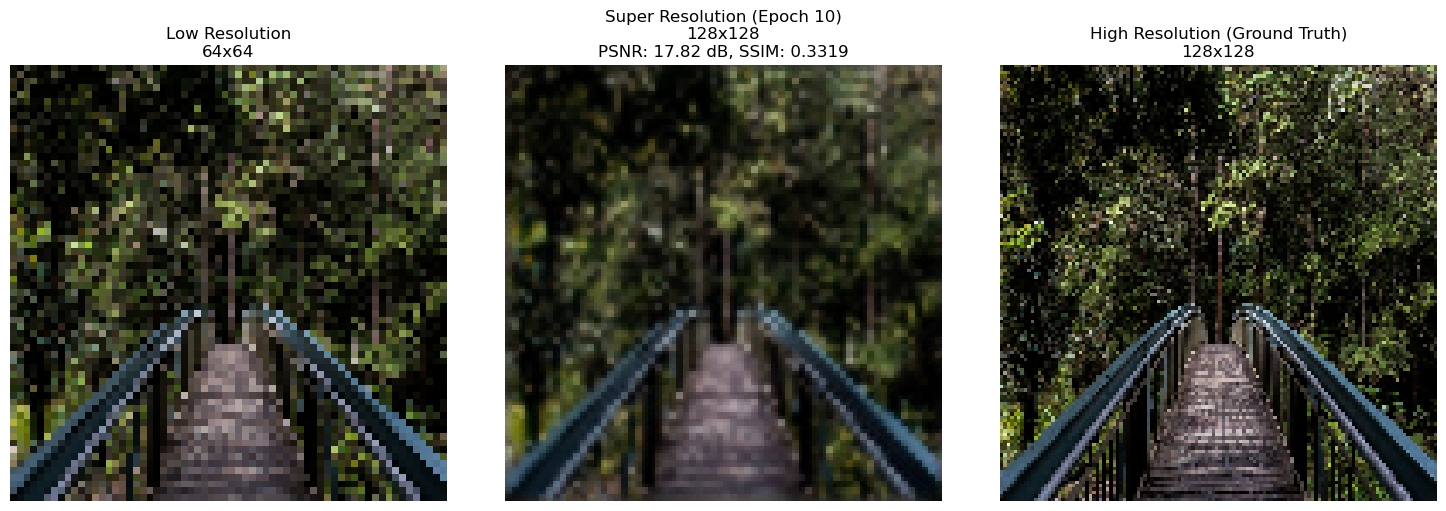

--------------------------------------------------------------------------------
50/50 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - loss: 0.0754 - psnr_metric: 18.9073 - ssim_metric: 0.5566 - val_loss: 0.0787 - val_psnr_metric: 18.6376 - val_ssim_metric: 0.5454 - learning_rate: 1.0000e-04
Epoch 11/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 178s 4s/step - loss: 0.0757 - psnr_metric: 18.9033 - ssim_metric: 0.5564 - val_loss: 0.0774 - val_psnr_metric: 18.6691 - val_ssim_metric: 0.5470 - learning_rate: 1.0000e-04
Epoch 12/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 191s 4s/step - loss: 0.0752 - psnr_metric: 18.9179 - ssim_metric: 0.5578 - val_loss: 0.0774 - val_psnr_metric: 18.6733 - val_ssim_metric: 0.5483 - learning_rate: 1.0000e-04
Epoch 13/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - loss: 0.0748 - psnr_metric: 18.9315 - ssim_metric: 0.5587 - val_loss: 0.0768 - val_psnr_metric: 18.6940 - val_ssim_metric: 0.5496 - learning_rate: 1.0000e-04
Epoch 14/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 246s 5s/step - loss: 0.0745 - psnr_metri

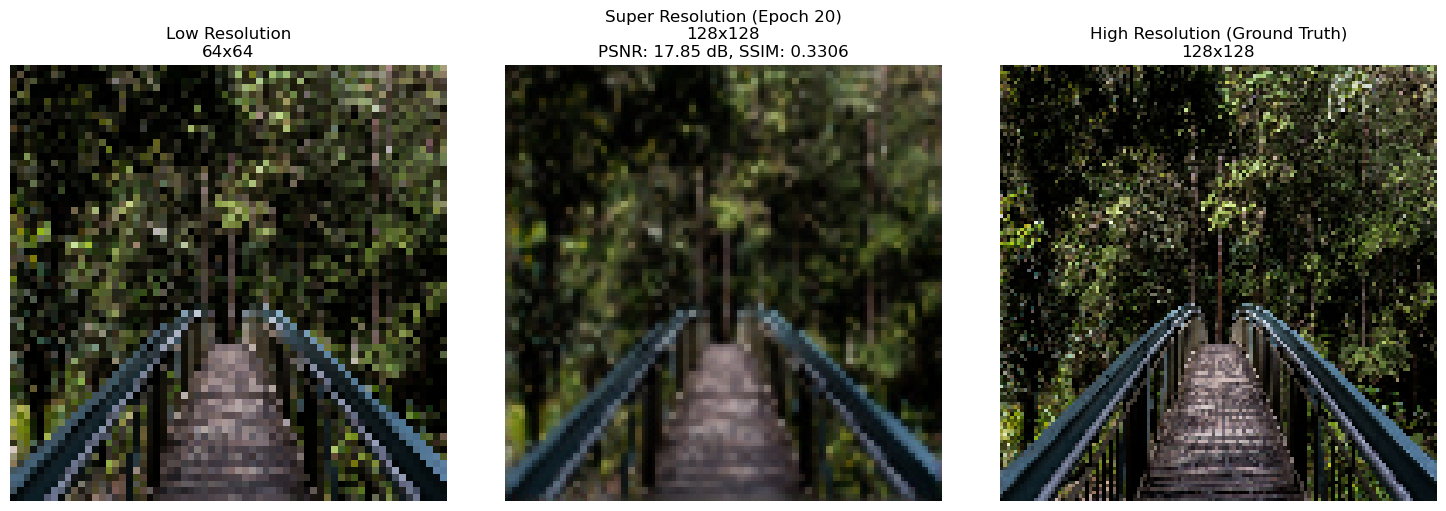

--------------------------------------------------------------------------------
50/50 ━━━━━━━━━━━━━━━━━━━━ 186s 4s/step - loss: 0.0740 - psnr_metric: 18.9583 - ssim_metric: 0.5606 - val_loss: 0.0759 - val_psnr_metric: 18.7202 - val_ssim_metric: 0.5506 - learning_rate: 1.0000e-04
Epoch 21/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 471s 10s/step - loss: 0.0736 - psnr_metric: 18.9701 - ssim_metric: 0.5611 - val_loss: 0.0759 - val_psnr_metric: 18.7202 - val_ssim_metric: 0.5500 - learning_rate: 1.0000e-04
Epoch 22/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 1320s 27s/step - loss: 0.0737 - psnr_metric: 18.9693 - ssim_metric: 0.5614 - val_loss: 0.0759 - val_psnr_metric: 18.7199 - val_ssim_metric: 0.5508 - learning_rate: 1.0000e-04
Epoch 23/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 223s 5s/step - loss: 0.0736 - psnr_metric: 18.9738 - ssim_metric: 0.5611 - val_loss: 0.0757 - val_psnr_metric: 18.7253 - val_ssim_metric: 0.5513 - learning_rate: 1.0000e-04
Epoch 24/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 866s 18s/step - loss: 0.0735 - psnr_m

In [ ]:
# Create callbacks
callbacks = create_callbacks(val_ds)

# Train model
start_time = time.time()

history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)

# Calculate training time
training_time = time.time() - start_time
training_hours = training_time / 3600
print(f"Training completed in {training_hours:.2f} hours")

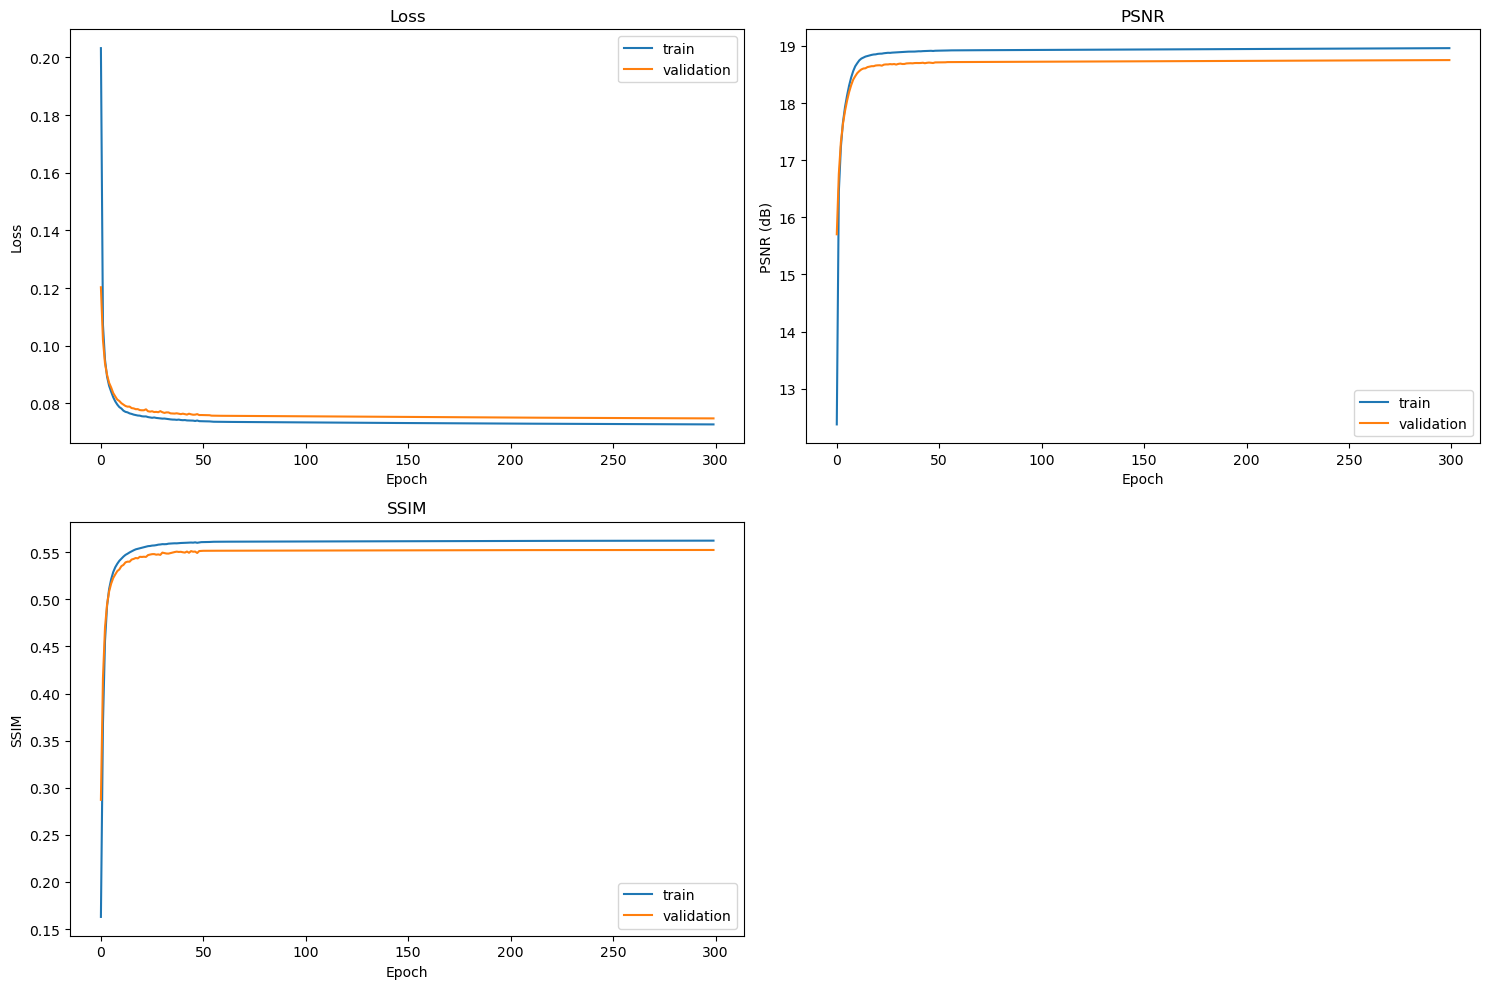


Evaluation Results:
PSNR: 18.75 dB
SSIM: 0.5524


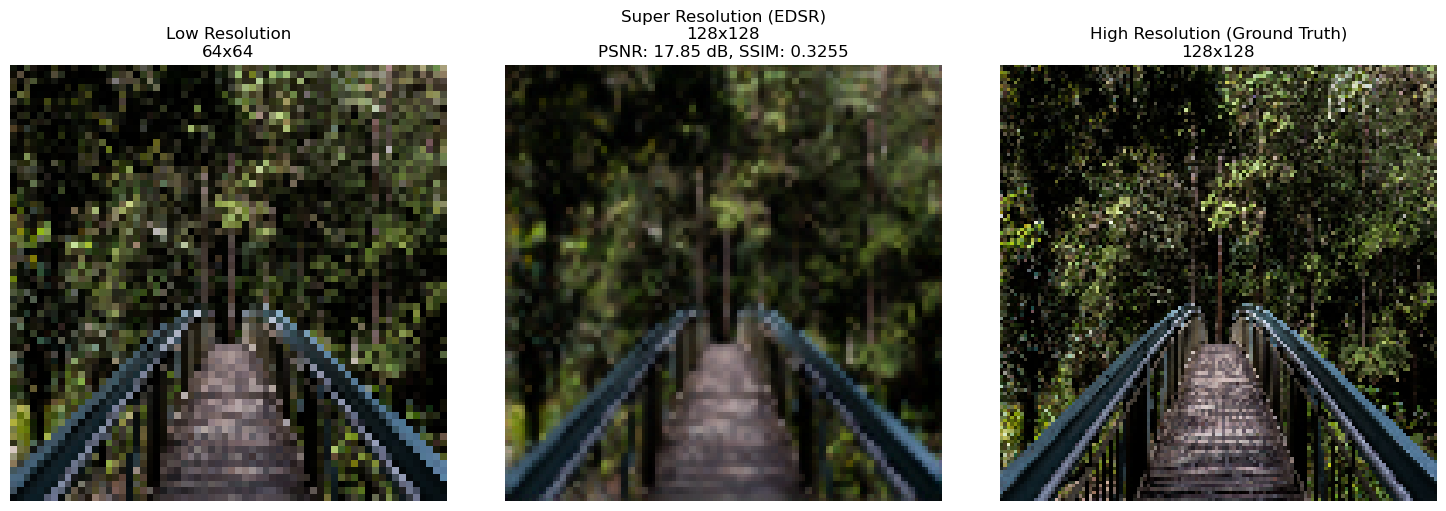

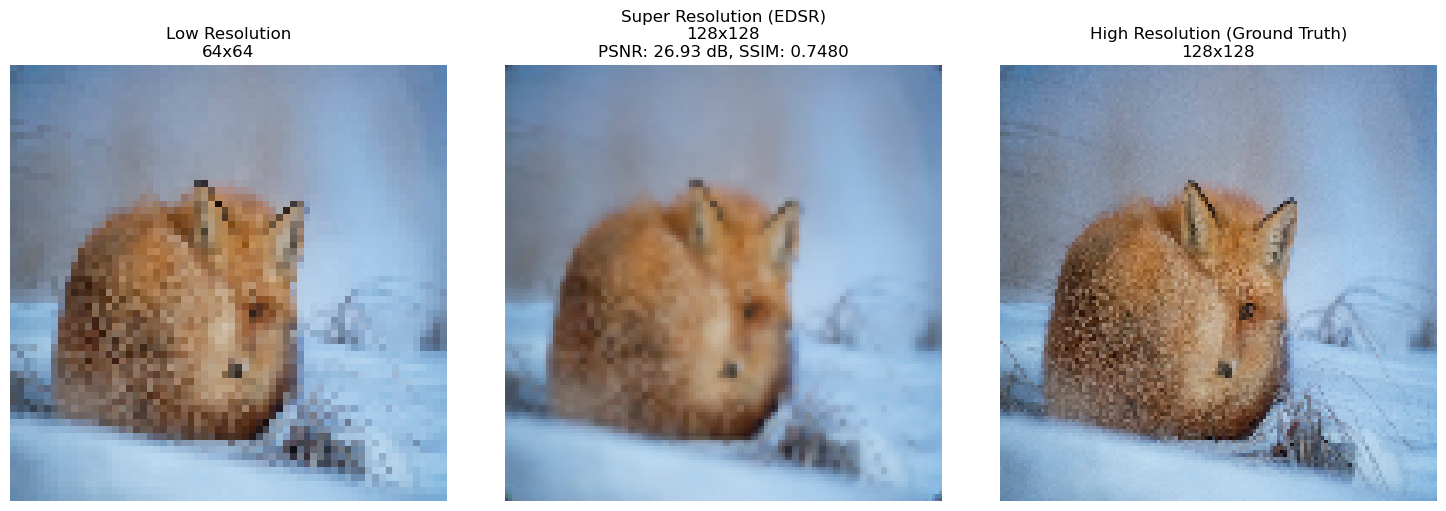

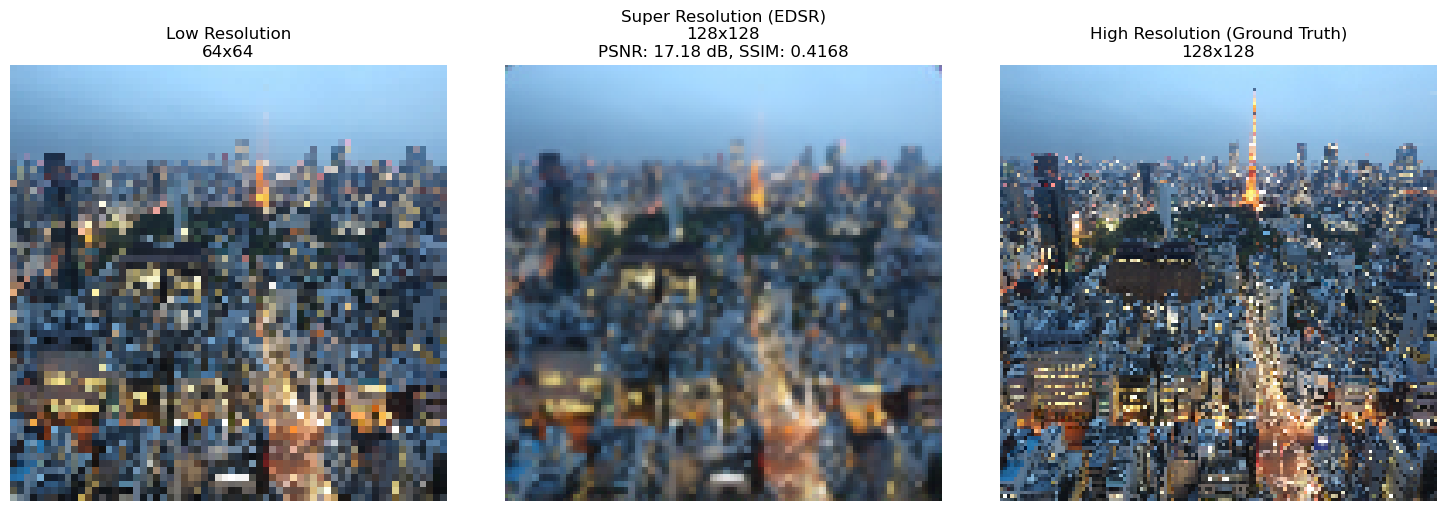

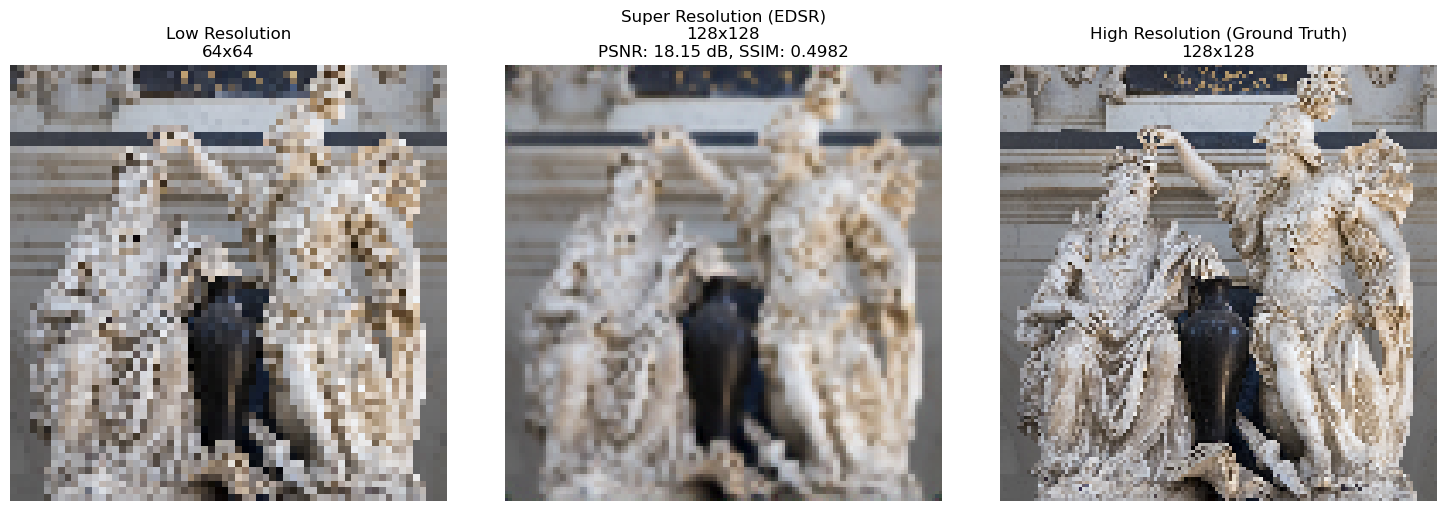

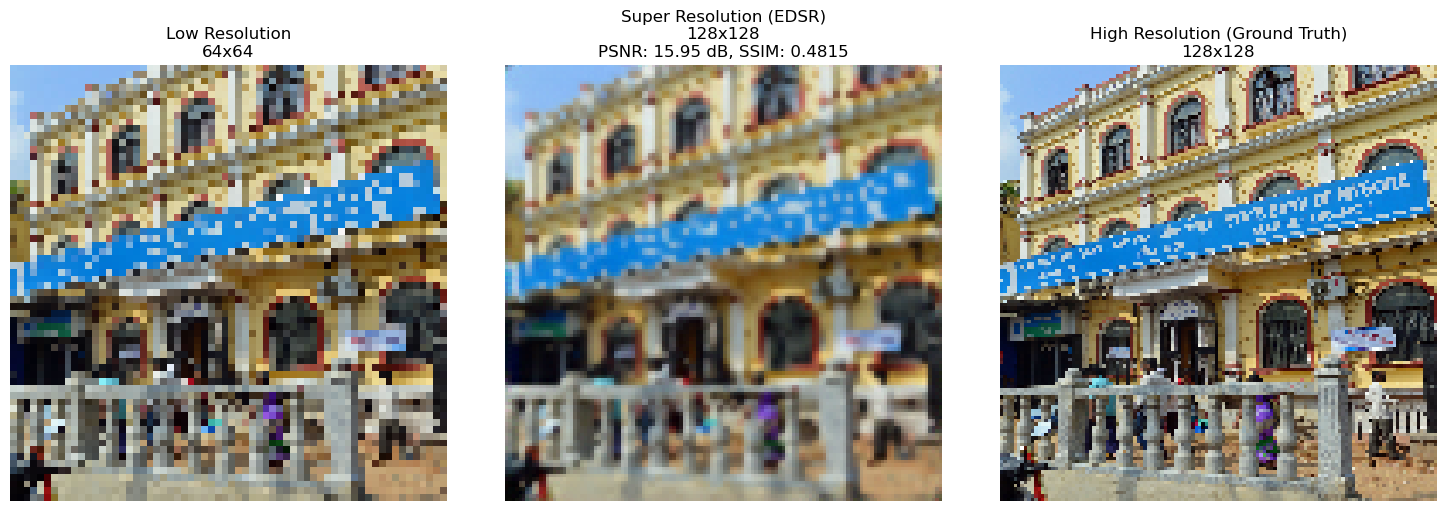

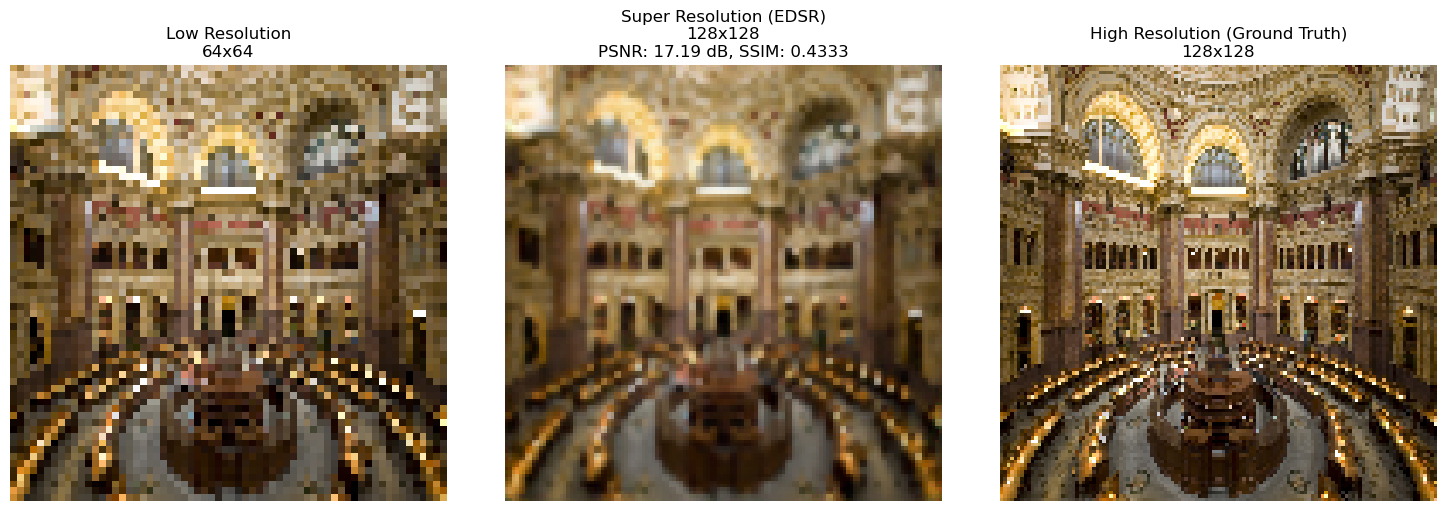

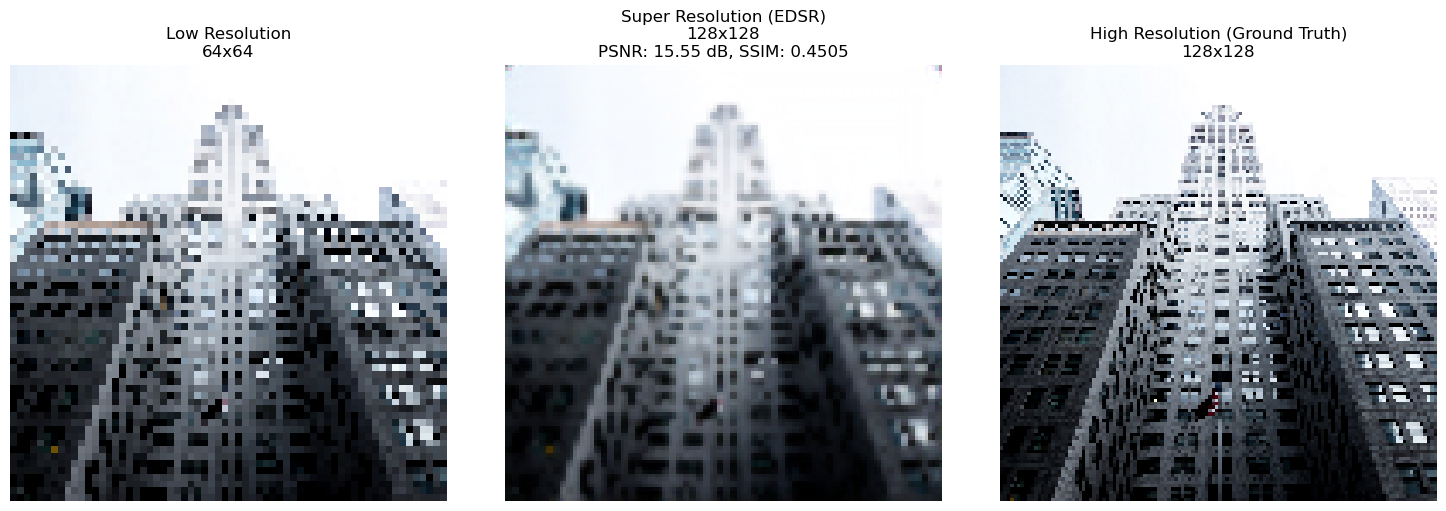

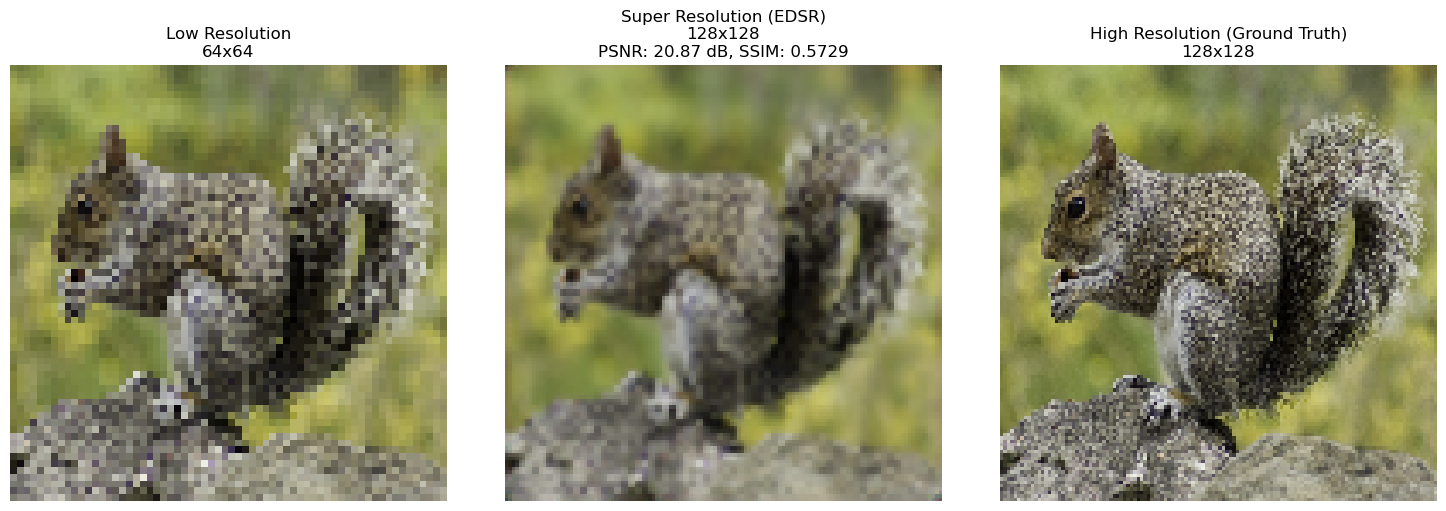

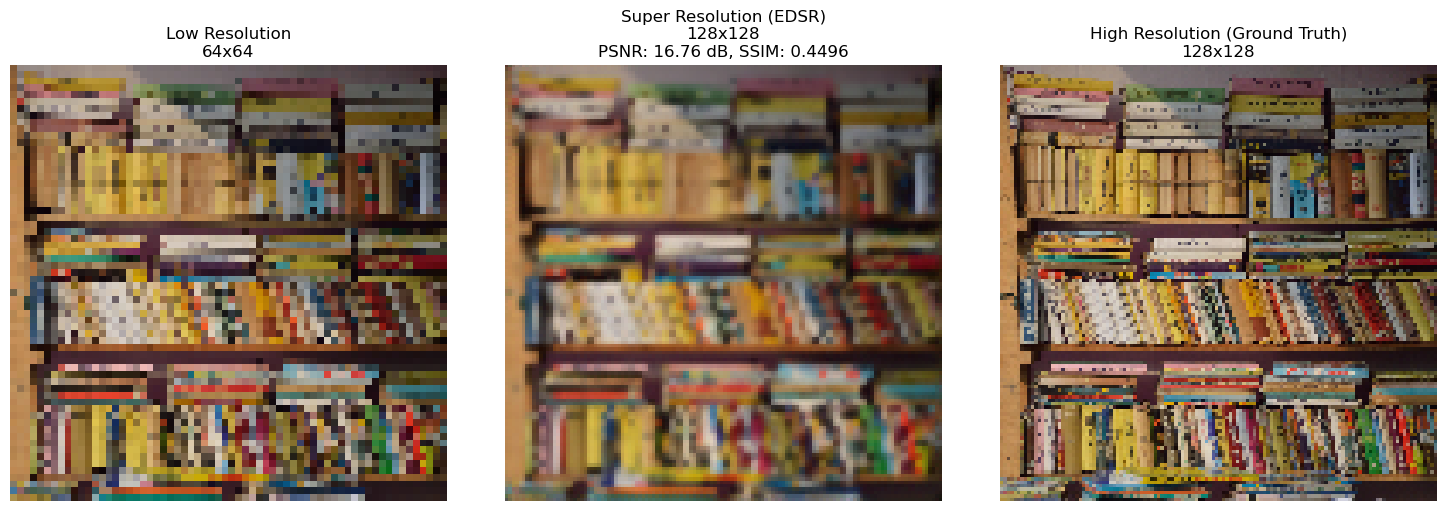

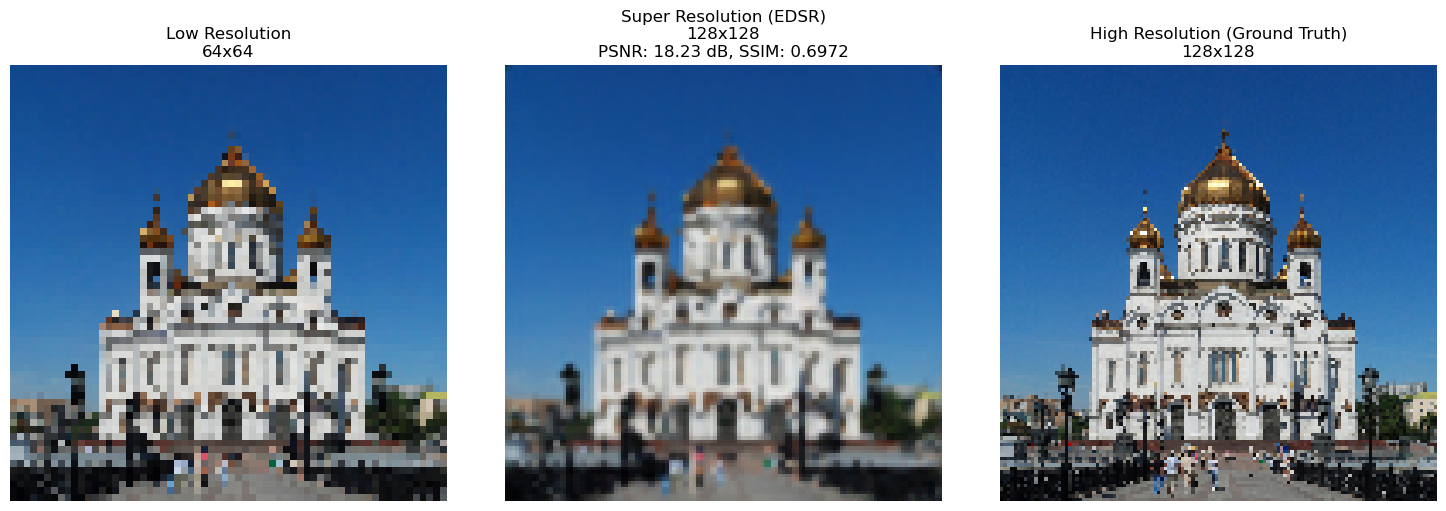

In [117]:
# Plot training history
plot_training_history(history)

# Evaluate model
eval_results = evaluate_model(model, val_ds)

# Visualize results
visualize_results(
    model,
    val_ds.take(5),
    num_samples=10,
)